In [1329]:
import re
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from textblob import TextBlob
import time 
from bs4 import BeautifulSoup
import requests
import time

tokenizer = TweetTokenizer()

In [1330]:
# открываем файл со второй части
import pandas as pd
clean_df= pd.read_csv('part_2.csv')
clean_df.drop('Unnamed: 0',inplace = True,axis = 1)
clean_df.shape

(2053, 26)

In [1331]:
clean_df[clean_df['best_cluster_churn'] == 1].shape

(732, 26)

In [1332]:
# причесываем сырые твиты от ссылок , стоп-слов
clf_text = []
stop_label = ["&amp;", "&gt;", "&lt;"]
for i in clean_df.index:
    # tokenized_tweets
    tweet = tokenizer.tokenize(clean_df.text[i])
    # fetch the full tweet text based on the link provided at the last of the truncated tweet

    
    
    tlinks = [w for w in tweet if re.search("^https:\w+", w)]
    words = [w.lower() for w in tweet if w not in tlinks and w not in stop_label]
    words = [w for w in words if w.isalpha() or 'att' in w or 'verizon' in w or 'tmobile' in w]
    clf_text.append(' '.join(words))
    
clean_df["clf_text"] = clf_text

In [1333]:
#  ранее мы выбрали euclidean_churn как лучшее разбиение , 
# теперь проверим ruled_based алгоритм на ранее отобранных нами отточных твитах



clean_df[clean_df['best_cluster_churn']==1].shape

(732, 27)

In [1334]:
# исключения

# text =[
# "@ATT @TMobile Fix your service in Queens, NY. It’s awful.",
# "She asked me what service I had, and I told her @ATT. She told me that @tmobile was way better and that they had better service in my area 😂😂😂. She went on to tell me that they had true unlimited and that AT&T did not.",
# "@ATT @TMobile What about the VI tho? all cover that or we gotta switch to @sprint",
# "Being a @ATT customer for 10 years and switch to @tmobilepr back in DEC was a bad decision.",
# "@ATT  Dude gotta try TMobile. @TMobileHelp and the Chicago team of experts are amazing. The team of experts anywhere!! And oddly Google too I had a good experience.",
# "The grass isn’t always greener...I miss you @tmobile. Can I come home? I hate it here @att",
# "@ATTHelp @ATT Can you transfer my old tmobile prepaid number to my new phone with AT&amp;T?",
# "@TMobile you have referral program? I'm making it my mission to free people from @ATT and bring them to @JohnLegere and his team!!!",
# "@TMobile @ATT And we Like @tmobilepr",
# "@ATT @TMobile @ATT stinks!"
# "@ATT Come to T Mobile. @TMobile",
# "@TMobile @verizon @sprint Do you suspend your long-standing customers account when they raise an inquiry about strange chargers on their account? Did that with @ATTHelp and they suspend my act instead of looking into my inquiry. Been a month now. How do I switch?",
# "What‚Äôs does @TMobile bring me for Christmas @verizon is giving out Disney+ https://t.co/McMRZJ6LOl",
# "Thinking about switching from @ATT to @sprint or at @TMobile. This decision is harder than I thought lol"]

In [1335]:
# алгоритм отбора по правилам

from textblob import TextBlob
import re

def getSubject(text):
#     carrier = ['ATT', 'Verizon', 'TMobile']
    # get the Subject of text
    subject = []
    if re.search(r'\b[Aa][Tt][Tt]\S*', text):
        subject.append('ATT')
    if re.search(r'\b[Vv][Ee][Rr][Ii][Zz][Oo][Nn]\S*', text):
        subject.append('Verizon')
    if re.search(r'\b[Tt][Mm][Oo][Bb][Ii][Ll][Ee]\S*', text):
        subject.append('TMobile')
    if re.search(r'\b[Vv][Zz][Ww][Ss]\S*', text):
        subject.append('Verizon')
    return subject


def getReason(text):
    # get the reason of text
    indicator = ['service','better','experts','disney','network','wifi','price','tower','coverage','family','horrible','awfull',
                'slow','free of charge','worst','worse','bad','price','money','can\'t stand','promise']
        # Suggestion1: focus on Comparative adj with tagging
    # Reason
    reason = []
    sentences = TextBlob(text).sentences
    for s in sentences:
        for i in indicator:
            if s not in reason and i in s.lower():
                reason.append(s.string)
    return reason


def getChurnCarrier(text):
    text = text.replace('&amp;', '')
    text = text.replace('T Mobile', 'tmobile')
    text = text.replace('and', '.')
    text = text.replace(',', '.')
    pol = {'other':0}
    subjects = getSubject(text)
    sentences = TextBlob(text).sentences
    for s in sentences:
        s = s.string
        # clean the sentense
        s = re.sub(r'@[Tt][Mm][Oo][Bb][Ii][Ll][Ee]\S*', "tmobile", s)
        s = re.sub(r'@JohnLegere\S*', "tmobile", s)
        s = re.sub(r'@[Aa][Tt][Tt]\S*', "att", s)
        s = re.sub(r'@[Vv][Ee][Rr][Ii][Zz][Oo][Nn]\S*', "verizon", s)
        s = re.sub(r'@[Vv][Zz][Ww][Ss]\S*', "verizon", s)
        tokens = TextBlob(s.lower()).words

        # special rules
        # Special Rule 1: switch to or stay...
        swObj = re.search(r'\bswitch\S*', s, re.I)
        trObj = re.search(r'\btransfer\S*', s, re.I)
        frObj = re.search(r'\bfree\S*', s, re.I)
        coObj = re.search(r'\bcome\S*', s, re.I)
        chObj = re.search(r'\bchange\S*', s, re.I)
        lvObj = re.search(r'\bleave\S*', s, re.I)
        lv2Obj = re.search(r'\bleaving\S*', s, re.I)
        stObj = re.search(r'\bstay\S*', s, re.I)
        wcObj = re.search(r'\bwelcome\S*', s, re.I)
        gbObj = re.search(r'\bgoodbye\S*', s, re.I)
        ciuObj= re.search(r'\bcontract is up\S*', s, re.I)
        if swObj!=None or trObj!=None or frObj!=None or coObj!=None or chObj!=None or lvObj!=None or lv2Obj!=None or stObj!=None or wcObj!=None or gbObj!=None or ciuObj!=None:
            v = 0
            counts = 0
            for w in tokens:
                if w == 'from': v = -0.8; continue
                elif w == 'to': v = 0.8; continue
                elif w == 'with': v = 0.5; continue
                for sub in subjects:
                    if sub.lower() == w:
                        pol[sub.lower()] = pol.get(sub.lower(), 0) + v
                        if v == 0.8:
                            counts += 1
            if counts == 0:
                # when switch to a carrier not belong to the Three
                for sub in subjects:
                    pol[sub.lower()] = pol.get(sub.lower(), 0) - 0.5
            # print(s, '\nfrom to: ', pol)

        # Special Rule 2: Like (Object)
        lkObj = re.search(r'\blike\S*', s, re.I)
        if lkObj:
            v = 0
            for w in tokens:
                if w == 'like': v = 0.5; continue
                for sub in subjects:
                    if sub.lower() == w:
                        pol[sub.lower()] = pol.get(sub.lower(), 0) + v
            # print('like', pol)

        # Special Rule 3: Disney and Verizon  
        veObj = re.search(r'\bverizon\S*', s, re.I)
        dyObj = re.search(r'\bdisney\S*', s, re.I)
        if veObj!=None and dyObj!=None:
            pol['verizon'] = pol.get('verizon', 0) + 0.5

        # sentiment analysis for segament carrier sentence
        contain = 0
        for sub in subjects:
            if sub.lower() in tokens:
                count = TextBlob(s).words.count(sub.lower())
                pol[sub.lower()] = pol.get(sub.lower(), 0) + count*TextBlob(s).polarity
                contain += 1
        if contain==0:
            pol['other'] += TextBlob(s).polarity
        # print(s, '\nsentiment: ', pol)

    # update the sentiment polarity of each carrier
    for k,v in pol.items():
        if k != 'other':
            pol[k] += pol['other']
    # print('original: ', pol)

    # sort the carrier by the score
    scores = []
    del pol['other']
    for k,v in pol.items():
        scores.append((v,k))
    scores.sort(reverse=True)
    print('scores: ', pol)

    # identify how user churn from one carrier to another
    from_carrier = []
    to_carrier = []
    if len(scores)>0:
        if scores[0][0] < 0:  # (-1, -2, -3)
            for s in scores:
                from_carrier.append(s[1])
        elif scores[0][0] > 0:  # (2, 1, 0)
            to_carrier.append(scores[0][1])
            for i in range(1,len(scores)):
                from_carrier.append(scores[i][1])
        else:  # (0, 0, 0); (0, -1, -2)/(0, 0, -1); 
            # Highest score is 0
            score,_ = zip(*scores)
            if sum(score) == 0:
                for s in scores:
                    from_carrier.append(s[1])
            else:
                for s in scores:
                    if s[0] == 0:
                        to_carrier.append(s[1])
                    else:
                        from_carrier.append(s[1])

    # print('Conclusion: Churn from ', from_carrier, ' to ',  to_carrier)
    return from_carrier,to_carrier


def getChurnAndReason(text):
    subject = getSubject(text)
    reason = getReason(text)
    from_carrier,to_carrier = getChurnCarrier(text)
    print("Subjects:", subject)
    print("Reason:", reason)
    print('Conclusion: Churn from ', from_carrier, ' to ',  to_carrier)
    return from_carrier,to_carrier,reason
    # improve the reason algorithm: only pick out clause not sentense

In [1336]:
# tweet6 = 'Dassit. IÕm not paying my phone bill anymore! @ATT yÕall can go ahead and turn this jawn off cause yÕall FOUL! IÕm going back to @TMobile'

# getChurnAndReason(tweet6)

In [1337]:
# по кластеризованным ранее данным, отмеченным как "отток" проверим наш rule_based алгоритм

churn_from = []
churn_to = []
churn_reason = []
for text in clean_df[clean_df['best_cluster_churn']==1].dropna(subset=['clf_text']).text.values:
    print(text)
    from_carrier,to_carrier,reason = getChurnAndReason(text)
    print()
    churn_from.append(from_carrier)
    churn_to.append(to_carrier)
    churn_reason.append(reason)

clean_df.loc[clean_df['best_cluster_churn']==1,'churn_from'] = churn_from
clean_df.loc[clean_df['best_cluster_churn']==1,'churn_to'] = churn_to
clean_df.loc[clean_df['best_cluster_churn']==1,'churn_reason'] = churn_reason

@TroyLLF We're sorry to hear that you're having this trouble, but we'll be happy to assist you. Is this for cellula… https://t.co/jrXZWbgfei
scores:  {}
Subjects: []
Reason: []
Conclusion: Churn from  []  to  []

RT @nazzo01: @VerizonSupport how do I confirm if there is an outage in my area?
scores:  {'verizon': 0.0}
Subjects: ['Verizon']
Reason: []
Conclusion: Churn from  ['verizon']  to  []

@jacklangstonn Please follow and dm us so that we can look into this for you.  ^JMB
scores:  {}
Subjects: []
Reason: []
Conclusion: Churn from  []  to  []

@VerizonSupport No I can’t get it to work
scores:  {'verizon': 0.0}
Subjects: ['Verizon']
Reason: []
Conclusion: Churn from  ['verizon']  to  []

@VerizonSupport Not working for me
scores:  {'verizon': 0.0}
Subjects: ['Verizon']
Reason: []
Conclusion: Churn from  ['verizon']  to  []

@jacklangstonn Hello Jack! You can check for an outage here https://t.co/gPQRK1a06x
^JMB
scores:  {}
Subjects: []
Reason: []
Conclusion: Churn from  []  to  []

@

scores:  {'verizon': 0.0}
Subjects: ['Verizon']
Reason: []
Conclusion: Churn from  ['verizon']  to  []

@VerizonSupport @Verizon its coming up as your service provider.
scores:  {'verizon': 0.0}
Subjects: ['Verizon']
Reason: ['@VerizonSupport @Verizon its coming up as your service provider.']
Conclusion: Churn from  ['verizon']  to  []

@VerizonSupport *if my package wasnt shipped
scores:  {'verizon': 0.0}
Subjects: ['Verizon']
Reason: []
Conclusion: Churn from  ['verizon']  to  []

@POMCORE We don't want you to feel that way! Let's see if we can turn that around for you here! What's going on? 
^KRT
scores:  {}
Subjects: []
Reason: []
Conclusion: Churn from  []  to  []

@VerizonSupport Mobile
scores:  {'verizon': 0.0}
Subjects: ['Verizon']
Reason: []
Conclusion: Churn from  ['verizon']  to  []

@JContreras2_ Were you experiencing an issue we may help with? ^JTP
scores:  {}
Subjects: []
Reason: []
Conclusion: Churn from  []  to  []

RT @laurieeconnors: Yo @VerizonSupport why is my inter

scores:  {'verizon': 0.0}
Subjects: ['Verizon']
Reason: []
Conclusion: Churn from  ['verizon']  to  []

@VerizonSupport Just DMd.
scores:  {'verizon': 0.0}
Subjects: ['Verizon']
Reason: []
Conclusion: Churn from  ['verizon']  to  []

@VerizonSupport Okay I did. Please respond.
scores:  {'verizon': 0.5}
Subjects: ['Verizon']
Reason: []
Conclusion: Churn from  []  to  ['verizon']

@VerizonSupport I am not sure where the workforce went too. It was just a pandemic?
scores:  {'verizon': -0.25}
Subjects: ['Verizon']
Reason: []
Conclusion: Churn from  ['verizon']  to  []

@VerizonSupport It’s cybercrime
scores:  {'verizon': 0.0}
Subjects: ['Verizon']
Reason: []
Conclusion: Churn from  ['verizon']  to  []

@VerizonSupport Beware
scores:  {'verizon': 0.0}
Subjects: ['Verizon']
Reason: []
Conclusion: Churn from  ['verizon']  to  []

@VerizonSupport I don’t understand why they do it?
scores:  {'verizon': 0.0}
Subjects: ['Verizon']
Reason: []
Conclusion: Churn from  ['verizon']  to  []

@VerizonSu

scores:  {'verizon': 0.0}
Subjects: ['Verizon']
Reason: []
Conclusion: Churn from  ['verizon']  to  []

@Verizon 5G ultra wideband is absolutely insane. #5gultrawideband #verizon https://t.co/hg3fCLM919
scores:  {'verizon': -1.0}
Subjects: ['Verizon']
Reason: []
Conclusion: Churn from  ['verizon']  to  []

@oncewheein @NWSL @Verizon I think they got that wrong ahahhah.
scores:  {'verizon': -0.5}
Subjects: ['Verizon']
Reason: []
Conclusion: Churn from  ['verizon']  to  []

@ishyhendrix @wateveridrc @CartierSellout @B_Ingram13 @Verizon I wanted to get that jersey
scores:  {'verizon': 0.0}
Subjects: ['Verizon']
Reason: []
Conclusion: Churn from  ['verizon']  to  []

@wateveridrc @Moody504__ @CartierSellout @B_Ingram13 @Verizon Can’t blame them cuz they gotta live in the south.
scores:  {'verizon': 0.13636363636363635}
Subjects: ['Verizon']
Reason: []
Conclusion: Churn from  []  to  ['verizon']

Verizon wireless is a luxury I wish I could afford 😩
scores:  {'verizon': 0.0}
Subjects: ['Veri

scores:  {'verizon': 0.0}
Subjects: ['Verizon']
Reason: []
Conclusion: Churn from  ['verizon']  to  []

@TheEllenShow @Xfinity @ellentube @YouTube @Verizon Verizon what you got for me
scores:  {'verizon': 0.0}
Subjects: ['Verizon']
Reason: []
Conclusion: Churn from  ['verizon']  to  []

@VZWSupport I did. Hanging out here.
scores:  {'verizon': 0.0}
Subjects: ['Verizon']
Reason: []
Conclusion: Churn from  ['verizon']  to  []

@VZWSupport MRE. I'm here.
scores:  {'verizon': 0.0}
Subjects: ['Verizon']
Reason: []
Conclusion: Churn from  ['verizon']  to  []

@VZWSupport who is in charge of your automated phone system when a user calls in on 611?
scores:  {'verizon': 0.0}
Subjects: ['Verizon']
Reason: []
Conclusion: Churn from  ['verizon']  to  []

@CaraTheDuck Here is more details of how spoofing works Cara. https://t.co/G2VfDTxJFQ ^VM
scores:  {}
Subjects: []
Reason: []
Conclusion: Churn from  []  to  []

@VZWSupport 34120... we have all noticed it since the hurricane.
scores:  {'verizon':

scores:  {}
Subjects: []
Reason: []
Conclusion: Churn from  []  to  []

@VZWSupport No. But thanks for offering.
scores:  {'verizon': 0.2}
Subjects: ['Verizon']
Reason: []
Conclusion: Churn from  []  to  ['verizon']

@ryanvaughan @VZWSupport Thank you for your service!! I'll try to do my part as well!
scores:  {'verizon': 0.0}
Subjects: ['Verizon']
Reason: ['@ryanvaughan @VZWSupport Thank you for your service!!']
Conclusion: Churn from  ['verizon']  to  []

@VZWSupport By the way, I appreciate the prompt reply!
scores:  {'verizon': 0.0}
Subjects: ['Verizon']
Reason: []
Conclusion: Churn from  ['verizon']  to  []

@VZWSupport For now, I am good. Finally, after 4 1/2 months, I rec'd an unemployment check.
scores:  {'verizon': 0.7}
Subjects: ['Verizon']
Reason: []
Conclusion: Churn from  []  to  ['verizon']

RT @JohnCha66894132: Who sucks more @CapitalOne @CapitalOneBiz or @VZWSupport
scores:  {'verizon': 0.1}
Subjects: ['Verizon']
Reason: []
Conclusion: Churn from  []  to  ['verizon']

H

Subjects: ['ATT']
Reason: []
Conclusion: Churn from  ['att']  to  []

RT @FrRecu: @jasonkilar This fight isn't over either! Please #RestoreTheSnyderVerse 🙏🏼 @jasonkilar @ATT @WarnerMedia @hbomax
scores:  {'att': 0.0}
Subjects: ['ATT']
Reason: []
Conclusion: Churn from  ['att']  to  []

RT @FrRecu: @jasonkilar You've seen what #ZackSnyder can do... take advantage of that! #RestoreTheSnyderVerse @jasonkilar @ATT @WarnerMedia…
scores:  {'att': 0.0}
Subjects: ['ATT']
Reason: []
Conclusion: Churn from  ['att']  to  []

@Lynda_Katerra @ATT Exactly
scores:  {'att': 0.25}
Subjects: ['ATT']
Reason: []
Conclusion: Churn from  []  to  ['att']

@DallasStars @StarsHangar @ATT Starting lineup?
scores:  {'att': 0.0}
Subjects: ['ATT']
Reason: []
Conclusion: Churn from  ['att']  to  []

@dreczz q att?
scores:  {'att': 0.0}
Subjects: ['ATT']
Reason: []
Conclusion: Churn from  ['att']  to  []

@yooniearth ve se nao eh att yoonie!!
scores:  {'att': 0.0}
Subjects: ['ATT']
Reason: []
Conclusion: Churn from 

scores:  {'att': 0.0}
Subjects: ['ATT']
Reason: []
Conclusion: Churn from  ['att']  to  []

RT @RTAyerCutSS: Joker and enchantress #OpSKWAD
#ReleaseTheAyerCut @hbomax @ATT https://t.co/As7goshemn
scores:  {'att': 0.0}
Subjects: ['ATT']
Reason: []
Conclusion: Churn from  ['att']  to  []

@BallySportsNOR @Shea_Carr @ATT Zip code 55430:

Presumably, this is because @TheCWtwincities is not prepared for… https://t.co/R4pTFm7xhi
scores:  {'att': 0.0}
Subjects: ['ATT']
Reason: []
Conclusion: Churn from  ['att']  to  []

RT @sylabdul_inc: 👀

This getting serious....

#ReleaseTheAyerCut @DavidAyerMovies

#RestoreTheSnyderVerse @ATT https://t.co/mhTvF18xww
scores:  {'att': -0.3333333333333333}
Subjects: ['ATT']
Reason: []
Conclusion: Churn from  ['att']  to  []

RT @jay_hernandez: @CutAyer @DavidAyerMovies @hbomax @ATT @WarnerMedia @jasonkilar Hey there friends. Diablo ain't dead. 🔥💀🔥
scores:  {'att': -0.2}
Subjects: ['ATT']
Reason: []
Conclusion: Churn from  ['att']  to  []

RT @SadProcessor: "

scores:  {}
Subjects: []
Reason: []
Conclusion: Churn from  []  to  []

@ctetris11 Hey Cesar, we can help you here. Meet us in a DM with more details about your trade-in, so we can work o… https://t.co/d6Ma2i4qc3
scores:  {}
Subjects: []
Reason: []
Conclusion: Churn from  []  to  []

@ATTHelp I’m not receiving any help or assistance from @ATT with my issue.
scores:  {'att': 0.0}
Subjects: ['ATT']
Reason: []
Conclusion: Churn from  ['att']  to  []

RT @TheManHimself__: @ATTHelp why is my internet so slow?!?
scores:  {'att': -0.37500000000000006}
Subjects: ['ATT']
Reason: ['RT @TheManHimself__: @ATTHelp why is my internet so slow?!']
Conclusion: Churn from  ['att']  to  []

RT @jennpedia: When you only have 5G available &amp; figure out just how fn slow it really is @ATT @ATTHelp
scores:  {'att': 0.15}
Subjects: ['ATT']
Reason: ['RT @jennpedia: When you only have 5G available &amp; figure out just how fn slow it really is @ATT @ATTHelp']
Conclusion: Churn from  []  to  ['att']

@damnnnn_

scores:  {'att': 0.0}
Subjects: ['ATT']
Reason: []
Conclusion: Churn from  ['att']  to  []

@omglazerkittens @ATTHelp @ATT probably gonna have to go through their executive relations team. 

they CAN do it,… https://t.co/ktVqnlIMoR
scores:  {'att': 0.0}
Subjects: ['ATT']
Reason: []
Conclusion: Churn from  ['att']  to  []

@ATTHelp I dm’d and no one has responded.
scores:  {'att': 0.0}
Subjects: ['ATT']
Reason: []
Conclusion: Churn from  ['att']  to  []

@NotPepeinVegas Sounds like me on the 📞 with @ATTHelp alllllllll daaaaaaaaay!!! 🔻🙃
scores:  {'att': 0.5}
Subjects: ['ATT']
Reason: []
Conclusion: Churn from  []  to  ['att']

@ATTHelp Wireless
scores:  {'att': 0.0}
Subjects: ['ATT']
Reason: []
Conclusion: Churn from  ['att']  to  []

RT @yulmbutler: @ATTHelp Where’s my trade in credit: Case ID CM20210312_xxxxxxxxx
scores:  {'att': 0.0}
Subjects: ['ATT']
Reason: []
Conclusion: Churn from  ['att']  to  []

@Swit_Ju1 Hey, we want you to stay. Meet us in a DM with more details about what's 

scores:  {'tmobile': -0.30000000000000004}
Subjects: ['TMobile']
Reason: ['@CNET Definitely slow as hell in Toledo @TMobile']
Conclusion: Churn from  ['tmobile']  to  []

@JonFreier @TMobile Blackberry = 5G phone ❤️
scores:  {'tmobile': 0.0}
Subjects: ['TMobile']
Reason: []
Conclusion: Churn from  ['tmobile']  to  []

@TerryConduff @TMobile @FortuneMagazine @MarkWaschbusch @SteveLessor @RJGomezIII @SamSindha @JonFreier And we're pr… https://t.co/kq8FSruWwP
scores:  {'tmobile': 0.0}
Subjects: ['TMobile']
Reason: []
Conclusion: Churn from  ['tmobile']  to  []

@TMobile @MikeSievert @TMobileBusiness @TMobileHelp If it’s called “Carrier Freedom” how is it my previous carrier… https://t.co/GaJZRU5Wkh
scores:  {'tmobile': -1.0}
Subjects: ['TMobile']
Reason: []
Conclusion: Churn from  ['tmobile']  to  []

@TMobile y’all got a new mascot? https://t.co/BCJMh1IhaJ
scores:  {'tmobile': 0.13636363636363635}
Subjects: ['TMobile']
Reason: []
Conclusion: Churn from  []  to  ['tmobile']

RT @NevilleRa

scores:  {'att': 0.0, 'tmobile': 0.0}
Subjects: ['ATT', 'TMobile']
Reason: []
Conclusion: Churn from  ['tmobile', 'att']  to  []

RT @ACMawards: Hint: They are nominated for Duo of the Year. #ACMWithUs @TMobile #ad
scores:  {'tmobile': 0.0}
Subjects: ['TMobile']
Reason: []
Conclusion: Churn from  ['tmobile']  to  []

@TraceWaWa @TMobile They posted this ended a while ago
scores:  {'tmobile': 0.0}
Subjects: ['TMobile']
Reason: []
Conclusion: Churn from  ['tmobile']  to  []

@ACMawards @TMobile Blake Sheldon and his mom!
scores:  {'tmobile': 0.0}
Subjects: ['TMobile']
Reason: []
Conclusion: Churn from  ['tmobile']  to  []

@ACMawards @TMobile Brothers Osbourne
scores:  {'tmobile': 0.0}
Subjects: ['TMobile']
Reason: []
Conclusion: Churn from  ['tmobile']  to  []

@ACMawards @TMobile Dan and Shay
scores:  {'tmobile': 0.0}
Subjects: ['TMobile']
Reason: []
Conclusion: Churn from  ['tmobile']  to  []

Crossing my fingers I win $5,000 from @TMobile 🤞 #5Gsfor5G #ContestOfTheWeek
scores:  {'tmob

scores:  {'tmobile': -0.8}
Subjects: ['TMobile']
Reason: []
Conclusion: Churn from  ['tmobile']  to  []

@bash784 @NevilleRay Oh no, that is never what we want to hear, Bashir! Please send us a DM so we can chat about wh… https://t.co/tH5g3VYuNR
scores:  {}
Subjects: []
Reason: []
Conclusion: Churn from  []  to  []

@ElementalShadow @MikeSievert We want to ensure that you get the answers that you need. Please send us a DM so we c… https://t.co/5cdR5sGLVY
scores:  {}
Subjects: []
Reason: []
Conclusion: Churn from  []  to  []

@TMobileHelp @NevilleRay I did you said there's nothing you can do about it it's your partner in that area
scores:  {'tmobile': 0.0}
Subjects: ['TMobile']
Reason: []
Conclusion: Churn from  ['tmobile']  to  []

@screamjessy Oh no. We'd love to help turn this around for you! DM us here so we can get started. Thanks!… https://t.co/LP35dYolP3
scores:  {}
Subjects: []
Reason: []
Conclusion: Churn from  []  to  []

@Bern44644788 @NevilleRay We want you to love your serv

C:\Users\au00174\AppData\Roaming\Python\Python37\site-packages\pandas\core\dtypes\missing.py:516: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.array(val, copy=False)
C:\Users\au00174\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
C:\Users\au00174\AppData\Roaming\Python\Python37\site-packages\pandas\core\internals\blocks.py:966: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or

In [1338]:
clean_df[clean_df['best_cluster_churn']==1]

,screen_name,carrier,location,date_time,text,clean_text,polarity,fact,hour,sense_dummy,...,frequency,euclidean_churn,chebyshev_churn,sqeuclidean_churn,naive_churn,best_cluster_churn,clf_text,churn_from,churn_to,churn_reason
10,VerizonSupport,verizonsupport,NaN,2021-04-14 23:07:07,@TroyLLF We're sorry to hear that you're havin...,sorry hear trouble happy assist cellula,0.033333,0,23,1,...,148,1,0,1,0,1,sorry to hear that having this trouble but be ...,[],[],[]
16,ShieldVoC,verizonsupport,"Stockholm, Sweden",2021-04-14 22:37:49,RT @nazzo01: @VerizonSupport how do I confirm ...,confirm outage area,0.000000,1,22,0,...,123,1,0,1,0,1,rt @verizonsupport how do i confirm if there i...,[verizon],[],[]
17,VerizonSupport,verizonsupport,NaN,2021-04-14 22:36:32,@jacklangstonn Please follow and dm us so that...,please follow look jmb,0.000000,1,22,0,...,148,1,0,1,0,1,please follow and dm us so that we can look in...,[],[],[]
18,jacklangstonn,verizonsupport,"Arkansas, USA",2021-04-14 22:36:30,@VerizonSupport No I can’t get it to work,get work,0.000000,1,22,0,...,3,1,0,1,0,1,@verizonsupport no i can t get it to work,[verizon],[],[]
19,jacklangstonn,verizonsupport,"Arkansas, USA",2021-04-14 22:35:40,@VerizonSupport Not working for me,not working,0.000000,1,22,0,...,3,1,0,1,0,1,@verizonsupport not working for me,[verizon],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2040,ZoeyHatesTrump,tmobilehelp,"Seattle, WA",2021-04-17 21:19:55,"@TMobileHelp @NevilleRay NO! Like I said, as s...",like said soon contract gone sprint,0.000000,1,21,0,...,4,1,0,1,0,1,@tmobilehelp no like i said as soon as my cont...,[tmobile],[],[]
2041,TMobileHelp,tmobilehelp,"Bellevue, WA",2021-04-17 21:19:33,@thcfarmdirect @MikeSievert We always want to ...,always want make sure getting service,0.500000,0,21,1,...,222,1,0,1,0,1,we always want to make sure you are getting th...,[],[],[@thcfarmdirect @MikeSievert We always want to...
2042,TMobileHelp,tmobilehelp,"Bellevue, WA",2021-04-17 21:19:19,"@omglazerkittens We're here to help, shoot us ...",help shoot traviscarey,0.000000,1,21,0,...,222,1,0,1,0,1,here to help shoot us a dm traviscarey,[],[],[]
2044,ZoeyHatesTrump,tmobilehelp,"Seattle, WA",2021-04-17 21:17:07,@TMobileHelp Why? So you can screw up my phone...,why screw phone forget,0.000000,1,21,0,...,4,1,0,1,0,1,@tmobilehelp why so you can screw up my phone ...,[],[tmobile],[]


In [1339]:
# если у нас есть значение в ['churn_from','churn_to','churn_reason'] -> ставим 1 в checked_churn
for i in clean_df[['churn_from','churn_to','churn_reason']].iterrows():
    if (type(i[1][0]) is list and len(i[1][0])) or (type(i[1][1]) is list and len(i[1][1])) or (type(i[1][2]) is list and len(i[1][2])):
        clean_df.loc[i[0],'checked_churn'] = 1
    


In [1340]:
clean_df[(clean_df['best_cluster_churn']==1) & (clean_df['checked_churn']==1)].shape

(606, 31)

In [1341]:
# проставим нули
clean_df['checked_churn'] = clean_df['checked_churn'].apply(lambda x: 0 if x !=1 else 1)
clean_df['checked_churn'].value_counts()

0    1447
1     606
Name: checked_churn, dtype: int64

In [1342]:
# сохраняем
clean_df.to_csv('part_3.csv')

In [1343]:
len(churn_from),len(churn_to), len(clean_df[clean_df['best_cluster_churn']==1].dropna(subset=['clf_text']).text.values)

(732, 732, 732)

In [1344]:
# в целях удобства визуализации создадим датафрейм churn_tweets

churn_tweets = clean_df[clean_df['best_cluster_churn']==1]

churn_tweets = churn_tweets.dropna(subset=['clf_text'])
churn_tweets.head(3)

,screen_name,carrier,location,date_time,text,clean_text,polarity,fact,hour,sense_dummy,...,euclidean_churn,chebyshev_churn,sqeuclidean_churn,naive_churn,best_cluster_churn,clf_text,churn_from,churn_to,churn_reason,checked_churn
10,VerizonSupport,verizonsupport,NaN,2021-04-14 23:07:07,@TroyLLF We're sorry to hear that you're havin...,sorry hear trouble happy assist cellula,0.033333,0,23,1,...,1,0,1,0,1,sorry to hear that having this trouble but be ...,[],[],[],0
16,ShieldVoC,verizonsupport,"Stockholm, Sweden",2021-04-14 22:37:49,RT @nazzo01: @VerizonSupport how do I confirm ...,confirm outage area,0.000000,1,22,0,...,1,0,1,0,1,rt @verizonsupport how do i confirm if there i...,[verizon],[],[],1
17,VerizonSupport,verizonsupport,NaN,2021-04-14 22:36:32,@jacklangstonn Please follow and dm us so that...,please follow look jmb,0.000000,1,22,0,...,1,0,1,0,1,please follow and dm us so that we can look in...,[],[],[],0


In [1345]:
# добавим столбцы оттока от, и оттока в
churn_tweets['churn_from'] = churn_from
churn_tweets['churn_to'] = churn_to
churn_tweets['churn_reason'] = churn_reason

In [1346]:
churn_tweets = churn_tweets[['carrier','clf_text','churn_from','churn_to','churn_reason']]
churn_tweets.shape

(732, 5)

In [1347]:
churn_tweets['churn_to'].apply(str).value_counts()

[]             563
['verizon']     66
['tmobile']     57
['att']         46
Name: churn_to, dtype: int64

In [1348]:

att_move_out = 0
att_move_in = 0
att_move_reason = []
ver_move_out = 0
ver_move_in = 0
ver_move_reason = []
tmo_move_out = 0
tmo_move_in = 0
tmo_move_reason = []

for c in churn_tweets.values:
    move_out = c[2]
    move_in = c[3]
    move_reason = c[4]
    
    if 'att' in move_out:
        att_move_out += 1
        att_move_reason += move_reason
    elif 'att' in move_in:
        att_move_in += 1
        
    if 'verizon' in move_out:
        ver_move_out += 1
        ver_move_reason += move_reason
    elif 'verizon' in move_in:
        ver_move_in += 1
        
    if 'tmobile' in move_out:
        tmo_move_out += 1
        tmo_move_reason += move_reason
    elif 'tmobile' in move_in:
        tmo_move_in += 1

In [1349]:
print(att_move_out)
print(att_move_in)


147
46


In [1350]:
print(ver_move_out)
print(ver_move_in)

187
66


In [1351]:
print(tmo_move_out)
print(tmo_move_in)


112
57


### Найти: как много твитов для оттока / по операторам

### Как много In / Out оттока

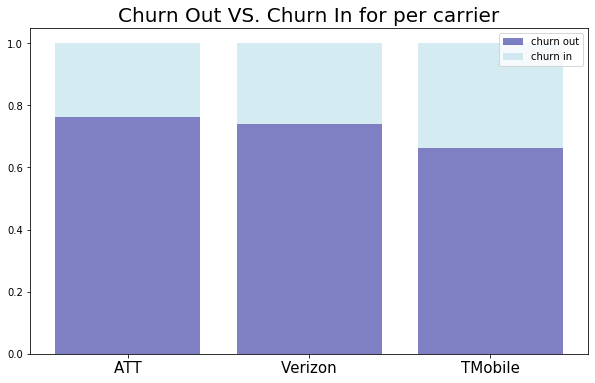

In [1352]:
# churn in/churn out %

import matplotlib.pyplot as plt
x_carrier = ['ATT','Verizon','TMobile']
churn_out_percent = []
churn_in_percent = []
churn_out_percent.append(att_move_out/(att_move_out+att_move_in))
churn_in_percent.append(att_move_in/(att_move_out+att_move_in))
churn_out_percent.append(ver_move_out/(ver_move_out+ver_move_in))
churn_in_percent.append(ver_move_in/(ver_move_out+ver_move_in))
churn_out_percent.append(tmo_move_out/(tmo_move_out+tmo_move_in))
churn_in_percent.append(tmo_move_in/(tmo_move_out+tmo_move_in))


plt.figure(figsize=(10,6))
p1 = plt.bar(x_carrier, churn_out_percent, color='darkblue',label='churn out',alpha=0.5)
p2 = plt.bar(x_carrier, churn_in_percent, bottom=churn_out_percent, color='lightblue', label='churn in',alpha=0.5)
plt.legend()
plt.xticks(fontsize=15)
plt.title('Churn Out VS. Churn In for per carrier', fontsize=20)
plt.show()

In [1353]:
# churn in/churn out 

import numpy as np

def drawPlot(neg, pos, name, title):
    bar_width = 0.3
    x = np.arange(len(name))
    plt.figure(figsize=(10, 5))
    plt.bar(x+bar_width/2, neg, width=bar_width, label="Churn Out", color='darkblue', alpha=0.5)
    plt.bar(x+bar_width*1.5, pos, width=bar_width, label="Churn In", color='lightblue', alpha=0.5)
    
    plt.legend(loc=0,fontsize=15)
    plt.xticks(x+bar_width, name, fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(title, fontsize=20)
    plt.grid(alpha=0.2)
    plt.ylabel('percentage',fontsize=20)
    
#     x_text = list(x)+list(x+bar_width)
#     y_text = neg + pos
#     for a,b in zip(x_text,y_text):
#         plt.text(a, b, b, ha='center', va='bottom', fontsize=8)
    plt.show()

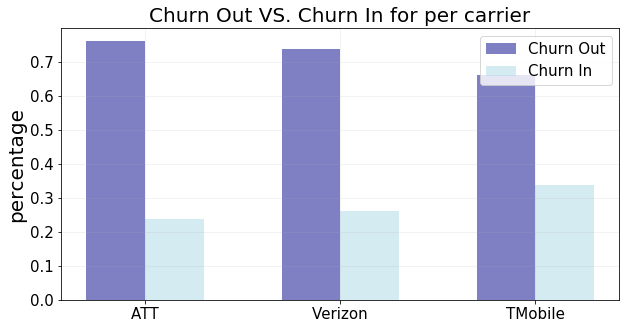

In [1354]:
drawPlot(churn_out_percent, churn_in_percent, x_carrier, 'Churn Out VS. Churn In for per carrier')

### Составить словарь причин оттока

In [1355]:

att_move_reason_text = ' '.join(att_move_reason)
ver_move_reason_text = ' '.join(ver_move_reason)
tmo_move_reason_text = ' '.join(tmo_move_reason)

In [1356]:
import nltk

# Corpus processing and cleanning
def cleanCorpusNLTK(corpus):
    # get words list
    words = nltk.tokenize.word_tokenize(corpus)
    # filter out non-alphabet value
    words = [w for w in words if w.isalpha()]
    # filter out the words that is less than 2 char, such as 'I'
    words = [w for w in words if len(w) > 2]
    # lower all alphabet 
    words = [w.lower() for w in words]
    # filter out 'amp'(&amp), 'u'(you), and 'http'
    words = [w for w in words if w not in ['amp', 'u', 'http', 'https', 'att', 'verizon', 'tmobile']]
    # filter out stopwords
    stop_words = nltk.corpus.stopwords.words('english')
    words = [w for w in words if w not in stop_words]
    # imporve linguistic ability in case of overstemming
    wordnet = nltk.stem.WordNetLemmatizer()
    lemmatized = [wordnet.lemmatize(w) for w in words]
    return lemmatized

In [1357]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def drawWordCloud(corpus):
    if len(corpus)!=0:
        text_corpus = ' '.join(cleanCorpusNLTK(corpus))
        wordcloud = WordCloud(width=500, height=500, background_color='white', 
                    min_font_size =12).generate(text_corpus)
        plt.imshow(wordcloud)
    else:
        return 'no words'

Why people wants to churn from their original carrier?


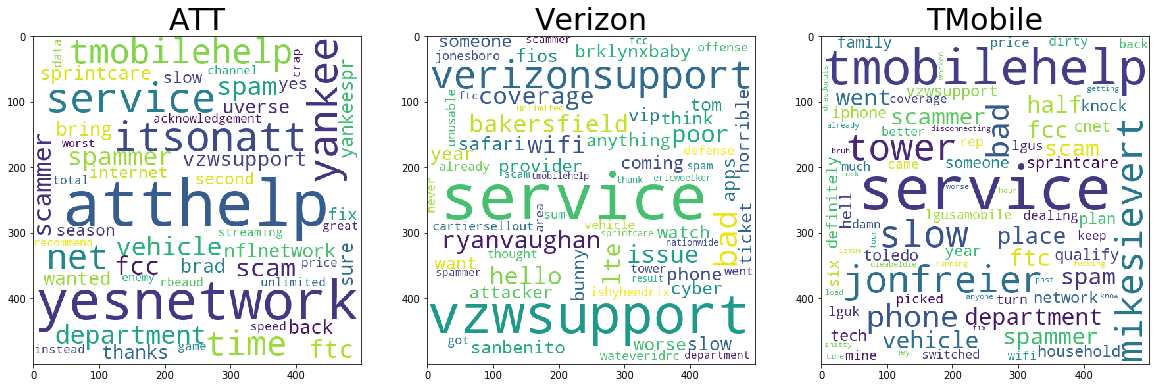

In [1358]:
print('Why people wants to churn from their original carrier?')
plt.figure(figsize=(20,10))
plt.subplot(131)
drawWordCloud(att_move_reason_text)
plt.title('ATT', fontsize=30)
plt.subplot(132)
drawWordCloud(ver_move_reason_text)
plt.title('Verizon', fontsize=30)
plt.subplot(133)
drawWordCloud(tmo_move_reason_text)
plt.title('TMobile', fontsize=30)
plt.show()

### Составить словарь "предложений по улучшению для операторов"

In [1359]:

def readReasons(move_reason):
    for m in move_reason:
        print(m,'\n')

In [1360]:
readReasons(att_move_reason)

RT @AlanStump1: 562-376-4834 vehicle services department #Scam #Scammer #Spam #Spammer @FTC @FCC @VZWSupport @TMobileHelp @sprintcare @ATT 

@ATT it’s time to bring back @nflnetwork to @Uverse 

@BradFalcone23 @Fire_JoeDouglas @ATT @YESNetwork @Yankees @YankeesPR Thanks Brad, but not sure why we all wanted to… https://t.co/JwIz8ruaq9 

RT @TheManHimself__: @ATTHelp why is my internet so slow?! 

@ATTHelp I now have no service!!!! 

@ItsOnATT @ATTHelp @YESNetwork Fix YES on AT&amp;T TV!! 

@rangertom10 @YESNetwork @ATT @ItsOnATT @Yankees Second time this season and no acknowledgement of it. 

@ATTHelp why is it the Nets game is on both @YESNetwork channels again? 

@lindblad_josh @rbeaud @ItsOnATT @YESNetwork @ATTHelp this is total crap! 

@YESNetwork @ATTHelp why are the Nets on instead of Yankees? 

Are you on the AT&amp;T TV streaming service? 

@IR0NxSAM @ATTHelp @TMobile @TMobileHelp I have unlimited data with 1gb speeds for a great price. 

I don't recommend them to my worst enemy

In [1361]:
readReasons(ver_move_reason)

Phone is slow in all apps and on Safari. 

RT @EvilJin69: @VerizonSupport @Verizon Poor LTE Coverage here in Bakersfield CA from 93301 &amp; 93311 why is this it's been 3 years not even… 

RT @brklynxbaby: @Verizon @VerizonSupport we want VIP bad bunny tickets not this @sanbenito https://t.co/4pwrB55LwT 

@VerizonSupport @Verizon Poor LTE Coverage here in Bakersfield CA from 93301 &amp; 93311 why is this it's been 3 years… https://t.co/TaAiKMXyv3 

@VerizonSupport @Verizon its coming up as your service provider. 

@J_Steinberger97 Hello Tom, are you having issues with your Verizon FiOS services? 

I can’t watch anything on wifi https://t.co/xou… 

@OGFatMA_ Hello, are you having issues with your Verizon services? 

@VerizonSupport It’s worse than you think 

@VerizonSupport Someone is a very horrible cyber attacker. 

@ishyhendrix @wateveridrc @CartierSellout @B_Ingram13 @Verizon We already got a bad offense and defense 

@ryanvaughan @Verizon @VZWSupport @Verizon @VZWSupport your serv

In [1362]:
readReasons(tmo_move_reason)

T-mobile had no service in half the places i went everyday.… 

RT @AlanStump1: 562-376-4834 vehicle services department #Scam #Scammer #Spam #Spammer @FTC @FCC @VZWSupport @TMobileHelp @sprintcare @ATT 

@JonFreier @TMobile We have six phones in our household on our family plan, can we all do this? 

@JonFreier @TMobile If I have T-Mobile service and an iPhone 11, does that qualify? 

@MikeSievert @TMobile Im a 20 year tower tech. 

@CNET Definitely slow as hell in Toledo @TMobile 

Did someone knock the Tmobile Towers down?! 

is the network down or.... 

@The_Alpha_Geek @LGUSAMobile @LGUS @LGUK I picked mine up from tmobile at the $599 price its at now. 

Came to @TMobile because of Verizon's dirty dealings and it turns out their reps are just as bad. 

RT @TherealDon_E: @mwmarksman0308 @MikeSievert @TMobile I just switched back to AT&amp;T.  Much better coverage now. 

@TMobile WHY TF MY WIFI KEEP DAMN DISCONNECTING 

@TMobile fix yo fucking service bruh! 

Hey @TMobileHelp why do I